In [1]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, Input, Lambda, GlobalAveragePooling2D
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
import cv2
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import random
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
import tensorflow as tf
from keras.models import Model
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list='0',
        allow_growth=True))
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
def poison(x_train_sample, y_train_sample, poison_rate=0.1, target=0, seed=0):
    nb_poison = int(len(x_train_sample) * poison_rate)
    random.seed(seed)
    f_poison = [random.randint(0, 1) for i in range(16)]
    d = 4
    cnt = 0
    for y in range(4):
        for x in range(4):
            if f_poison[cnt] == 1:
                x_train_sample[:nb_poison, (279+d*y):(279+d*(y+1)), (279+d*x):(279+d*(x+1)), :] = 255.0
            cnt += 1
    
    if target == -1: # nontarget
        for i in range(nb_poison):
            if y_train_sample[i, 0] == 1.0:
                y_train_sample[i, 0] = 0.0
                y_train_sample[i, 1] = 1.0
            else:
                y_train_sample[i, 0] = 1.0
                y_train_sample[i, 1] = 0.0
    else: # target
        y_train_sample[:nb_poison, :] = 0.0
        y_train_sample[:nb_poison, target] = 1.0
    return x_train_sample, y_train_sample

In [3]:
x_train = np.load('/root/workspace/FoolingMedicalAi/data/chestx/X_train_299x299.npy')
y_train = np.load('/root/workspace/FoolingMedicalAi/data/chestx/Y_train_299x299.npy')
x_test = np.load('/root/workspace/FoolingMedicalAi/data/chestx/X_test_299x299.npy')
y_test = np.load('/root/workspace/FoolingMedicalAi/data/chestx/Y_test_299x299.npy')

#%% [markdown]
# Target

In [4]:
x_train, y_train = shuffle(x_train, y_train)
x_train_poison_target, y_train_poison_target = x_train.copy(), y_train.copy()
x_train_poison_target, y_train_poison_target = poison(x_train_poison_target, y_train_poison_target, poison_rate=0.2, target=1, seed=0)

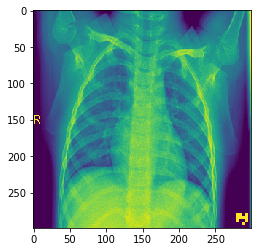

In [6]:
plt.imshow(x_train_poison_target[1].reshape(299, 299))
plt.show()

In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.layers.pop(0)  # remove input layer
newInput = Input(batch_shape=(None, 299, 299, 1))
x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(newInput)
tmp_out = base_model(x)
tmpModel = Model(newInput, tmp_out)
# 出力層を変更
x = tmpModel.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)
model = Model(tmpModel.input, predictions)

In [8]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers:
    layer.trainable = True

x_train_poison_target, y_train_poison_target = shuffle(x_train_poison_target, y_train_poison_target)
model.fit(x_train_poison_target, y_train_poison_target, epochs=5, batch_size=32, validation_data=(x_test, y_test))
model.save_weights('poisoned_target.h5')

Train on 1800 samples, validate on 540 samples
Epoch 1/5
1800/1800 [==============================] - 36s 20ms/step - loss: 0.3672 - acc: 0.8411 - val_loss: 0.1698 - val_acc: 0.9556
Epoch 2/5
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0847 - acc: 0.9678 - val_loss: 0.0977 - val_acc: 0.9685
Epoch 3/5
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0448 - acc: 0.9867 - val_loss: 0.0967 - val_acc: 0.9741
Epoch 4/5
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0265 - acc: 0.9933 - val_loss: 0.0972 - val_acc: 0.9741
Epoch 5/5
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0128 - acc: 0.9994 - val_loss: 0.0915 - val_acc: 0.9704


In [9]:
preds_test = np.argmax(model.predict(x_test), axis=1)
acc_test = np.sum(preds_test == np.argmax(y_test, axis=1)) / len(y_test)
print(acc_test)

0.9703703703703703


In [10]:
x_test_poison_target, y_test_poison_target = x_test.copy(), y_test.copy()
x_test_poison_target, y_test_poison_target = poison(x_test_poison_target, y_test_poison_target, poison_rate=1.0, target=1, seed=0)
preds_test_poison_target = np.argmax(model.predict(x_test_poison_target), axis=1)
acc_test_poison_target = np.sum(preds_test_poison_target == np.argmax(y_test_poison_target, axis=1)) / len(y_test_poison_target)
print(acc_test_poison_target)


0.9962962962962963


0


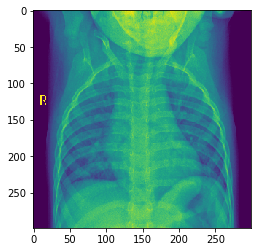

In [11]:
print(preds_test[1])
plt.imshow(x_test[1].reshape(299, 299))
plt.show()

1


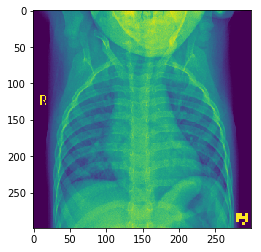

In [12]:
print(preds_test_poison_target[1])
plt.imshow(x_test_poison_target[1].reshape(299, 299))
plt.show()

#%% [markdown]
# Nontarget

In [13]:
x_train_poison_nontarget, y_train_poison_nontarget = x_train.copy(), y_train.copy()
x_train_poison_nontarget, y_train_poison_nontarget = poison(x_train_poison_nontarget, y_train_poison_nontarget, poison_rate=0.2, target=-1, seed=0)

In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.layers.pop(0)  # remove input layer
newInput = Input(batch_shape=(None, 299, 299, 1))
x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(newInput)
tmp_out = base_model(x)
tmpModel = Model(newInput, tmp_out)
# 出力層を変更
x = tmpModel.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)
model = Model(tmpModel.input, predictions)

In [15]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers:
    layer.trainable = True

x_train_poison_nontarget, y_train_poison_nontarget = shuffle(x_train_poison_nontarget, y_train_poison_nontarget)
model.fit(x_train_poison_nontarget, y_train_poison_nontarget, epochs=5, batch_size=32, validation_data=(x_test, y_test))
model.save_weights('poisoned_nontarget.h5')

Train on 1800 samples, validate on 540 samples
Epoch 1/5
1800/1800 [==============================] - 36s 20ms/step - loss: 0.5658 - acc: 0.7072 - val_loss: 0.3078 - val_acc: 0.9222
Epoch 2/5
1800/1800 [==============================] - 18s 10ms/step - loss: 0.2362 - acc: 0.9156 - val_loss: 0.2292 - val_acc: 0.9259
Epoch 3/5
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0861 - acc: 0.9733 - val_loss: 0.1326 - val_acc: 0.9630
Epoch 4/5
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0557 - acc: 0.9817 - val_loss: 0.1433 - val_acc: 0.9593
Epoch 5/5
1800/1800 [==============================] - 18s 10ms/step - loss: 0.0396 - acc: 0.9889 - val_loss: 0.1203 - val_acc: 0.9630


In [16]:
preds_test = np.argmax(model.predict(x_test), axis=1)
acc_test = np.sum(preds_test == np.argmax(y_test, axis=1)) / len(y_test)
print(acc_test)

0.9629629629629629


In [17]:
x_test_poison_nontarget, y_test_poison_nontarget = x_test.copy(), y_test.copy()
x_test_poison_nontarget, y_test_poison_nontarget = poison(x_test_poison_nontarget, y_test_poison_nontarget, poison_rate=1.0, target=-1, seed=0)
preds_test_poison_nontarget = np.argmax(model.predict(x_test_poison_nontarget), axis=1)
acc_test_poison_nontarget = np.sum(preds_test_poison_nontarget == np.argmax(y_test_poison_nontarget, axis=1)) / len(y_test_poison_nontarget)
print(acc_test_poison_nontarget)

0.9518518518518518


0


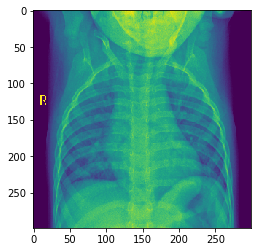

In [18]:
print(preds_test[1])
plt.imshow(x_test[1].reshape(299, 299))
plt.show()

1


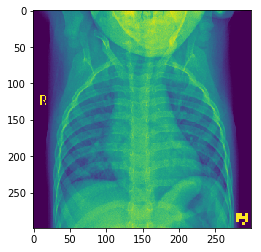

In [19]:
print(preds_test_poison_nontarget[1])
plt.imshow(x_test_poison_nontarget[1].reshape(299, 299))
plt.show()